In [430]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.spatial.distance import euclidean as euc
import numpy as np
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
np.random.seed(0)
import warnings
from simpsons_modeling_functions import r2_score_lr
from visualize import generate_moons_df, preprocess, plot_boundaries
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 60)

## Working with Kaggle dataset

In [18]:
ls

Data collection.ipynb                 all_star_rosters.pickle
Kaggle data.ipynb                     all_star_votes.pickle
NBA All Stars 2000-2016 - Sheet1.csv  data-3RdaG.csv
Players.csv                           player_data.csv
Seasons_Stats.csv


In [254]:
all_stars2000_2016 = pd.read_csv("NBA All Stars 2000-2016 - Sheet1.csv")

In [681]:
# Initially was variable "all_stars2000_2016"

master_df = pd.read_csv("Seasons_Stats.csv")
master_df = master_df[(master_df["Year"] >= 2000.0) & (players["Year"] <= 2016.00) & (players["Year"] != 1999.0)].drop(columns="Unnamed: 0")
master_df["Year"] = master_df["Year"].astype(int)
master_df["Player"] = master_df["Player"].str.strip("*")
master_df.drop(columns=["blanl", "blank2"], inplace=True)
master_df = master_df.reset_index()
master_df.drop(columns="index", inplace=True)

In [682]:
# Adding All-Star info to existing player df

all_star_yes_no_column = []
all_star_name_column = []
all_star_how_voted_column = []
for year in master_df["Year"].unique():
    all_players_df = master_df[master_df["Year"] == year]
    year_players = all_players_df["Player"]
    all_stars_df = all_stars2000_2016[all_stars2000_2016["Year"] == year]
    for guy in year_players:
        all_star_name_column.append(guy)
        if guy == "Metta World Peace" or guy == "Ron Artest":
            if "Metta World Peace" in list(all_stars_df["Player"]) or "Ron Artest" in list(all_stars_df["Player"]):
                all_star_yes_no_column.append("Yes")
                selection_type = all_stars_df[all_stars_df["Player"] == guy]["Selection Type"]
                all_star_how_voted_column.append(selection_type)
            else:
                all_star_yes_no_column.append("No")
                all_star_how_voted_column.append("N/a")
        else:
            if guy in list(all_stars_df["Player"]):
                all_star_yes_no_column.append("Yes")
                selection_type = all_stars_df[all_stars_df["Player"] == guy]["Selection Type"]
                all_star_how_voted_column.append(selection_type)
            else:
                all_star_yes_no_column.append("No")
                all_star_how_voted_column.append("N/a")

all_star_details_df = pd.DataFrame({"Player (check)": all_star_name_column, "All-Star?": all_star_yes_no_column, "Selection process": all_star_how_voted_column})

# Updating resulting df and then adding it to "master_df"

master_df[all_star_details_df.columns] = all_star_details_df

# Cutting guys who played fewer than 5 games, primarily to drop the Marcus Williams row causing problems in the function below (two guys named Marcus Williams played in the late 2000s)
#master_df = master_df.drop(master_df[(master_df["G"] < 5) & (master_df["Player"] != "Jeremy Lin")].index)
#master_df = master_df.reset_index().drop(columns="index")

In [683]:
# If a guy got traded he is listed multiple times: with his different team stats and again with his total stats

trade_dupes = []
years = list(master_df["Year"].unique())
for year in years:
    all_players_df = master_df[master_df["Year"] == year]
    year_players = all_players_df["Player"]
    players_list = list(master_df[master_df["Year"] == year]["Player"])
    for guy in list(set(players_list)):
        if players_list.count(guy) > 1:
            if len(master_df[(master_df["Player"] == guy) & (master_df["Tm"] != "TOT") & (master_df["Year"] == year)]["Age"].unique()) == 1:
                dupe_players_index = master_df[(master_df["Player"] == guy) & (master_df["Tm"] != "TOT") & (master_df["Year"] == year)].sort_values(by="G", ascending=False).index
                new_team_index = dupe_players_index[0]
                trade_dupes.extend(list(dupe_players_index))
                tot_index = master_df[(master_df["Player"] == guy) & (master_df["Tm"] == "TOT") & (master_df["Year"] == year)].index[0]
                new_team = master_df.iloc[new_team_index]["Tm"]
                master_df.iloc[tot_index, 4] = new_team

# Dropping last remaining "TOT" set for Marcus Williams in 2008
marcus_williams_dupe_index = master_df[(master_df["Player"] == "Marcus Williams") & (master_df["Tm"] != "TOT") & (master_df["Year"] == 2008) & (master_df["Age"] == 21.0)].sort_values(by="G", ascending=False).index
new_marcus_team_index = marcus_williams_dupe_index[0]
trade_dupes.extend(list(marcus_williams_dupe_index))
tot_marcus_index = master_df[(master_df["Player"] == "Marcus Williams") & (master_df["Tm"] == "TOT") & (master_df["Year"] == 2008) & (master_df["Age"] == 21.0)].index[0]
new_team = master_df.iloc[new_marcus_team_index]["Tm"]
master_df.iloc[tot_marcus_index, 4] = new_team

# Dropping the duplicate rows 
trade_dupes.sort(reverse=True)
for row in trade_dupes:
    master_df.drop(row, inplace=True)
                #master_df.drop(for_dropping, inplace=True)


In [685]:
master_df[master_df["Tm"] == "TOT"]

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player (check),All-Star?,Selection process


In [686]:
# Checking to make sure number of All-Star appearances is correct
# Initially asterisks proved to be a problem so I stripped them
# Then Ron Artest/Metta World Peace 

In [401]:
# Adding, importantly, a column called "All-Star next season?"

sorted_master_df = master_df.sort_values(by=["Player", "Year"]).reset_index().drop(columns=["index", "Player (check)"])
next_year_column = []

for i in range(0, (len(list(sorted_master_df["Player"])))-1):
    if sorted_master_df.iloc[i]["Player"] == sorted_master_df.iloc[(i+1)]["Player"]:
        if sorted_master_df.iloc[(i+1)]["All-Star?"] == "Yes":
            next_year_column.append("Yes")
        else:
            next_year_column.append("No")
    else:
        next_year_column.append("No")

# Because last player in his last year (Big Z) can't make All-Star Game next year    
next_year_column.append("No")

sorted_master_df["All-Star next season?"] = next_year_column
sorted_master_df["All-Star next season?"] = sorted_master_df["All-Star next season?"].replace(to_replace={"Yes": 1, "No": 0})

In [402]:
# Creating new column and re-indexing for ease of recognition

sorted_master_df["Player, year"] = sorted_master_df["Player"] + ', ' + sorted_master_df["Year"].astype(str)
reindexed_master_df = sorted_master_df.set_index("Player, year")

In [403]:
#reindexed_master_df["MPG"] = reindexed_master_df["MP"] / reindexed_master_df["G"]
reindexed_master_df[reindexed_master_df[features]["PER"].isna()]

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,All-Star?,Selection process,All-Star next season?
"Player, year",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Alex Scales, 2006",2006,Alex Scales,SG,27.0,SAS,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,-6.0,1.6,-4.4,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,N/a,0
"Damion James, 2013",2013,Damion James,SF,25.0,BRK,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,-5.5,0.3,-5.2,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,No,N/a,0
"JamesOn Curry, 2010",2010,JamesOn Curry,PG,24.0,LAC,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,-6.7,-0.2,-6.9,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,N/a,0


In [410]:
reindexed_master_df.drop(reindexed_master_df[reindexed_master_df["PER"].isna()].index)

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,All-Star?,Selection process,All-Star next season?
"Player, year",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"A.C. Green, 2000",2000,A.C. Green,PF,36.0,LAL,82.0,82.0,1929.0,11.2,0.482,0.010,0.245,9.0,17.9,13.5,5.9,1.4,0.7,11.0,11.0,1.7,3.3,5.0,0.124,-2.0,1.8,-0.2,0.9,173.0,387.0,0.447,1.0,4.0,0.250,172.0,383.0,0.449,0.448,66.0,95.0,0.695,160.0,326.0,486.0,80.0,53.0,18.0,53.0,127.0,413.0,No,N/a,0
"A.C. Green, 2001",2001,A.C. Green,PF,37.0,MIA,82.0,1.0,1411.0,11.2,0.492,0.019,0.343,9.0,17.3,13.2,4.8,1.2,0.4,10.8,14.4,1.1,2.1,3.2,0.110,-3.2,0.2,-3.0,-0.3,144.0,324.0,0.444,0.0,6.0,0.000,144.0,318.0,0.453,0.444,79.0,111.0,0.712,107.0,206.0,313.0,39.0,30.0,8.0,45.0,119.0,367.0,No,N/a,0
"A.J. Bramlett, 2000",2000,A.J. Bramlett,C,23.0,CLE,8.0,0.0,61.0,-0.4,0.190,0.000,0.000,21.7,18.5,20.1,0.0,0.8,0.0,12.5,17.1,-0.2,0.1,-0.2,-0.129,-10.5,-6.3,-16.8,-0.2,4.0,21.0,0.190,0.0,0.0,NaN,4.0,21.0,0.190,0.190,0.0,0.0,NaN,12.0,10.0,22.0,0.0,1.0,0.0,3.0,13.0,8.0,No,N/a,0
"A.J. Guyton, 2001",2001,A.J. Guyton,PG,22.0,CHI,33.0,8.0,630.0,10.3,0.495,0.359,0.094,1.8,5.1,3.4,18.1,0.8,0.6,10.7,16.5,0.4,-0.1,0.3,0.020,-1.5,-4.4,-5.9,-0.6,78.0,192.0,0.406,27.0,69.0,0.391,51.0,123.0,0.415,0.477,15.0,18.0,0.833,10.0,26.0,36.0,64.0,9.0,5.0,24.0,35.0,198.0,No,N/a,0
"A.J. Guyton, 2002",2002,A.J. Guyton,PG,23.0,CHI,45.0,6.0,607.0,11.8,0.477,0.504,0.111,2.3,6.3,4.2,23.6,0.9,0.9,12.6,22.2,0.0,0.0,0.1,0.006,-0.3,-4.4,-4.7,-0.4,88.0,244.0,0.361,46.0,123.0,0.374,42.0,121.0,0.347,0.455,22.0,27.0,0.815,12.0,32.0,44.0,81.0,10.0,7.0,37.0,23.0,244.0,No,N/a,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zydrunas Ilgauskas, 2007",2007,Zydrunas Ilgauskas,C,31.0,CLE,78.0,78.0,2130.0,18.0,0.527,0.001,0.242,12.9,20.0,16.4,10.2,1.2,3.6,13.8,21.7,2.6,4.0,6.6,0.148,-0.6,2.6,2.0,2.1,385.0,793.0,0.485,0.0,1.0,0.000,385.0,792.0,0.486,0.485,155.0,192.0,0.807,242.0,357.0,599.0,123.0,48.0,98.0,141.0,257.0,925.0,No,N/a,0
"Zydrunas Ilgauskas, 2008",2008,Zydrunas Ilgauskas,C,32.0,CLE,73.0,73.0,2222.0,18.7,0.522,0.001,0.276,13.1,22.2,17.5,8.5,0.8,4.3,12.0,22.9,2.9,3.2,6.1,0.131,-1.3,1.2,-0.1,1.1,417.0,879.0,0.474,0.0,1.0,0.000,417.0,878.0,0.475,0.474,195.0,243.0,0.802,263.0,419.0,682.0,104.0,34.0,120.0,135.0,247.0,1029.0,No,N/a,0
"Zydrunas Ilgauskas, 2009",2009,Zydrunas Ilgauskas,C,33.0,CLE,65.0,65.0,1765.0,18.0,0.523,0.054,0.240,11.0,21.6,16.5,6.4,0.9,3.8,10.1,23.8,2.1,3.5,5.6,0.151,-1.9,1.0,-0.9,0.5,342.0,724.0,0.472,15.0,39.0,0.385,327.0,685.0,0.477,0.483,139.0,174.0,0.799,157.0,333.0,490.0,64.0,28.0,84.0,90.0,183.0,838.0,No,N/a,0


In [478]:
reindexed_master_df["Tm"].unique()

array(['LAL', 'MIA', 'CLE', 'CHI', 'GSW', 'IND', 'WAS', 'MIN', 'TOT',
       'HOU', 'ORL', 'NOH', 'TOR', 'CHO', 'PHI', 'NJN', 'LAC', 'ATL',
       'UTA', 'CHA', 'BOS', 'DAL', 'NYK', 'DEN', 'NOP', 'POR', 'BRK',
       'PHO', 'DET', 'SAS', 'MEM', 'SEA', 'OKC', 'SAC', 'MIL', 'CHH',
       'VAN', 'NOK'], dtype=object)

## First attempt at KNN

In [411]:
# Using features I am suspecting will have high correlation
# 3 rows had NaNs in PER column (played < 5 games each)
reindexed_master_df = reindexed_master_df.drop(reindexed_master_df[reindexed_master_df["PER"].isna()].index)

features = ["Age", "PTS", "AST", "PER"]

X = reindexed_master_df[features]
y = reindexed_master_df["All-Star next season?"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val)

In [412]:
# Scaling training set (for now) and testing set (for later)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [477]:
# Picking All-Stars function (start)
 
logr = LogisticRegression(penalty="none")

logr.fit(X_train_scaled, y_train)

val_predictions = logr.predict(X_val_scaled)

classification_report(y_val, val_predictions)

prob_predictions = logr.predict_proba(X_val_scaled)
prob_dict = dict(zip(list(X_val.index), list(prob_predictions)))

years_list = [year.split(", ")[1] for year in prob_dict.keys()]
years_list = list(set(years_list))
years_list.sort()

for year in years_list:
    eligible_players = [[player, list(chance)[1]] for player, chance in prob_dict.items() if player.split(", ")[1] == year]
    top_24 = [[player, chance] for player, chance in sorted(eligible_players, key=lambda item: item[1], reverse=True)][:24]
    print("Top 24 most likely All-Stars in {}: {}".format(year, (", ".join([all_star[0].split(", ")[0] for all_star in top_24]))))
    
    
#top_20 = [[player, chance] for player, chance in sorted(prob_dict.items(), key=lambda item: item[1][1], reverse=True)][:20]
#top_20

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
Top 24 most likely All-Stars in 2000: Kevin Garnett, Tim Duncan, Chris Webber, Karl Malone, Jerry Stackhouse, Steve Francis, Tracy McGrady, Keith Van, Terrell Brandon, Cuttino Mobley, Raef LaFrentz, Kenny Anderson, Reggie Miller, Steve Smith, Derrick Coleman, Ron Mercer, Tim Thomas, Bob Sura, Jason Williams, Tyrone Nesby, Marcus Camby, Lindsey Hunter, Malik Sealy, Shawn Bradley
Top 24 most likely All-Stars in 2001: Tracy McGrady, Gary Payton, Lamar Odom, Andre Miller, Steve Nash, Jermaine O'Neal, Quentin Richardson, Clarence Weatherspoon, Voshon Lenard, Doug Christie, Chauncey Billups, Marc Jackson, Toni Kukoc, Brent Barry, Courtney Alexander, Shawn Bradley, Stromile Swift, Ricky Davis, Rick Fox, Howard Eisley, Jacque Vaughn, Glen Rice, Jamaal Magloire, Milt Palacio
Top 24 most likely All-Stars in 2002: Shawn Marion, Rasheed Wallace, Cuttino Mobley, J

In [442]:
X_val.index

Index(['Marty Conlon, 2000', 'Jeff Trepagnier, 2002', 'Oliver Miller, 2004',
       'Stephen Graham, 2007', 'Jusuf Nurkic, 2015', 'Joel Anthony, 2014',
       'Walter Herrmann, 2008', 'Nick Young, 2010', 'Henry Walker, 2010',
       'Dan Langhi, 2002',
       ...
       'Greg Buckner, 2006', 'Khris Middleton, 2015', 'Patrick Ewing, 2011',
       'Doug Christie, 2005', 'Arnett Moultrie, 2013', 'Felton Spencer, 2002',
       'Mike Bibby, 2004', 'Matt Bonner, 2006', 'Mo Williams, 2014',
       'Tony Battie, 2009'],
      dtype='object', name='Player, year', length=1453)

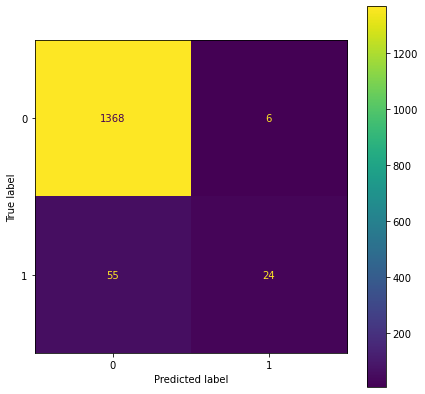

In [427]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(logr, X_val_scaled, y_val, ax=ax);

In [414]:
# Trying KNN


nn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

nn.fit(X_train_scaled, y_train)

predictions = nn.predict(X_val_scaled)

rmse = np.sqrt(mean_squared_error(y_val, predictions))

#print(f'Root Mean Squared Error: {rmse:.2f}')

In [435]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)

axes[0].set_title(f'KNeighborsClassifier with k={nn.n_neighbors}')
plot_boundaries(nn, X_val_scaled, X_train_scaled, ax=axes, show_test=True, plot_probas=False)

axes[1].set_title('Logistic Regression')
plot_boundaries(logr, X_val_scaled, X_train_scaled, ax=axes[1], plot_probas=False, show_test=True)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices